<a href="https://colab.research.google.com/github/NightWalker888/ai_painting_journey/blob/main/lesson19/LoRA_train_nouns_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 检查GPU环境。如提示无GPU，需要点击「修改」-「笔记本设置」-「GPU-T4」，然后点击右上角的连接按键。
!nvidia-smi

Sun Mar 10 15:30:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# 安装datasets工具包
!pip install datasets -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 7.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


a pixel art character with square black glasses, a hotdog-shaped head and a peachy-colored body on a warm background
a pixel art character with square black sunglasses, a shower-shaped head and a blue-colored body on a cool background
a pixel art character with square dark green glasses, a yeti-shaped head and a redpinkish-colored body on a cool background
a pixel art character with square dark gray glasses, a void-shaped head and a teal-colored body on a warm background


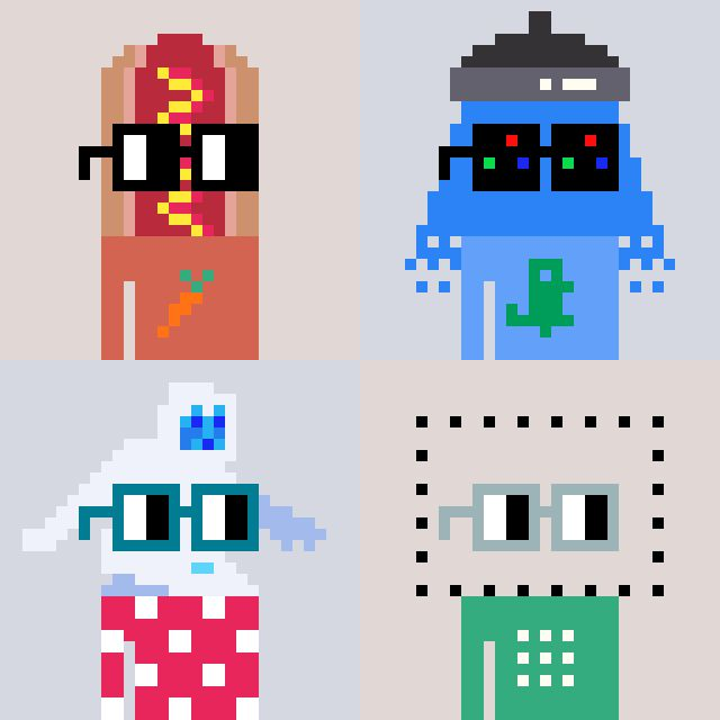

In [3]:
from datasets import load_dataset
from PIL import Image

# 加载pokemon数据集
# dataset = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
dataset = load_dataset("m1guelpf/nouns", split="train")

width, height = 360, 360

# 检查数据集中的4张图
new_image = Image.new('RGB', (2*width, 2*height))

new_image.paste(dataset[0]["image"].resize((width, height)), (0, 0))
new_image.paste(dataset[1]["image"].resize((width, height)), (width, 0))
new_image.paste(dataset[2]["image"].resize((width, height)), (0, height))
new_image.paste(dataset[3]["image"].resize((width, height)), (width, height))

# 检查数据集中的4个prompt
for idx in range(4):
  print(dataset[idx]["text"])

display(new_image)

In [4]:
import os
import zipfile
import shutil
import time
from subprocess import getoutput
from IPython.utils import capture
from google.colab import drive

In [5]:
# 设置项目需要的各种路径，比如基础模型存放路径、LoRA模型训练后的存放路径等
root_dir = os.path.abspath("/content")
deps_dir = os.path.join(root_dir, "deps")
repo_dir = os.path.join(root_dir, "kohya-trainer")
training_dir = os.path.join(root_dir, "LoRA")
pretrained_model = os.path.join(root_dir, "pretrained_model")
vae_dir = os.path.join(root_dir, "vae")
config_dir = os.path.join(training_dir, "config")

accelerate_config = os.path.join(repo_dir, "accelerate_config/config.yaml")
tools_dir = os.path.join(repo_dir, "tools")
finetune_dir = os.path.join(repo_dir, "finetune")

# TODO：在新的notebook中，这段代码可以删除
for store in [
    "root_dir",
    "deps_dir",
    "repo_dir",
    "training_dir",
    "pretrained_model",
    "vae_dir",
    "accelerate_config",
    "tools_dir",
    "finetune_dir",
    "config_dir",
]:
    with capture.capture_output() as cap:
        del cap

安装基础环境

In [ ]:
repo_url = "https://github.com/Linaqruf/kohya-trainer"
bitsandytes_main_py = "/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py"
branch = ""
install_xformers = True
verbose = False

def read_file(filename):
    with open(filename, "r") as f:
        contents = f.read()
    return contents


def write_file(filename, contents):
    with open(filename, "w") as f:
        f.write(contents)


def clone_repo(url):
    if not os.path.exists(repo_dir):
        os.chdir(root_dir)
        !git clone {url} {repo_dir}
    else:
        os.chdir(repo_dir)
        !git pull origin {branch} if branch else !git pull


def install_dependencies():
    s = getoutput('nvidia-smi')

    !pip install {'-q' if not verbose else ''} --upgrade -r requirements.txt
    !pip install {'-q' if not verbose else ''} torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1+cu118 torchtext==0.15.1 torchdata==0.6.0 --extra-index-url https://download.pytorch.org/whl/cu118 -U

    if install_xformers:
        !pip install {'-q' if not verbose else ''} xformers==0.0.19 triton==2.0.0 -U

    from accelerate.utils import write_basic_config

    if not os.path.exists(accelerate_config):
        write_basic_config(save_location=accelerate_config)


def main():
    os.chdir(root_dir)

    for dir in [
        deps_dir,
        training_dir,
        config_dir,
        pretrained_model,
        vae_dir
    ]:
        os.makedirs(dir, exist_ok=True)

    clone_repo(repo_url)

    os.chdir(repo_dir)
    !apt --fix-broken install
    !apt install aria2 {'-qq' if not verbose else ''}

    install_dependencies()
    time.sleep(3)

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
    os.environ["BITSANDBYTES_NOWELCOME"] = "1"
    os.environ["SAFETENSORS_FAST_GPU"] = "1"

    cuda_path = "/usr/local/cuda-11.8/targets/x86_64-linux/lib/"
    ld_library_path = os.environ.get("LD_LIBRARY_PATH", "")
    os.environ["LD_LIBRARY_PATH"] = f"{ld_library_path}:{cuda_path}"

main()


fatal: couldn't find remote ref if
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
aria2 is already the newest version (1.36.0-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:

下载基础模型

In [ ]:
# 下面提供了一些模型的下载链接，你可以到Hugging Face和CivitAI上获取更多模型。

# "Anything-v3-1": "https://huggingface.co/cag/anything-v3-1/resolve/main/anything-v3-1.safetensors",
# "AnyLoRA": "https://huggingface.co/Linaqruf/stolen/resolve/main/pruned-models/AnyLoRA_noVae_fp16-pruned.safetensors",
# "AnyLoRA-anime-mix": "https://huggingface.co/Lykon/AnyLoRA/resolve/main/AAM_Anylora_AnimeMix.safetensors",
# "AnimePastelDream": "https://huggingface.co/Lykon/AnimePastelDream/resolve/main/AnimePastelDream_Soft_noVae_fp16.safetensors",
# "Chillout-mix": "https://huggingface.co/Linaqruf/stolen/resolve/main/pruned-models/chillout_mix-pruned.safetensors",
# "OpenJourney-v4": "https://huggingface.co/prompthero/openjourney-v4/resolve/main/openjourney-v4.ckpt",
# "Stable-Diffusion-v1-5": "https://huggingface.co/Linaqruf/stolen/resolve/main/pruned-models/stable_diffusion_1_5-pruned.safetensors"

In [ ]:
# 下载你要用的基础模型。这些我用的是anything_v5基础模型，你可以根据喜欢进行更换。
pretrained_model_name_or_path = "/content/pretrained_model/anything_v5.safetensors"
!wget -c https://civitai.com/api/download/models/90854 -O $pretrained_model_name_or_path

准备数据

In [ ]:
# 创建训练数据路径
train_data_dir = os.path.join(root_dir, "LoRA/train_data/nouns")
os.makedirs(train_data_dir, exist_ok=True)

print(f"Your train data directory : {train_data_dir}")

In [ ]:
from PIL import Image
from io import BytesIO
from datasets import load_dataset
import os
from tqdm import tqdm

dataset = load_dataset("m1guelpf/nouns")

# 遍历所有图片并保存
for split in dataset.keys():
    for index, item in enumerate(tqdm(dataset[split])):
        image = item['image']
        image.save(os.path.join(train_data_dir, f"{split}_image_{index}.png"))
        prompt = item["text"]
        with open(os.path.join(train_data_dir, f"{split}_image_{index}.caption"), 'w') as fw:
            fw.write(prompt)

        if index >= 500:
          break

# **操作说明: 需要将你准备的照片放置在上面的路径下，比如这里的路径是：/content/LoRA/train_data/pokemon**

In [ ]:
# 使用BLIP模型给你的图片加上prompt，用于训练。
# BLIP是一个多模态生成算法，输入图片，得到图片的prompt描述信息。
# 对于我们使用的Pokemon数据集，本身已经具有prompt描述信息。如果你使用自己的图片训练，并且没有prompt，可以用用下面的代码来生成prompt。

# import os

# os.chdir(finetune_dir)

# batch_size = 8
# max_data_loader_n_workers = 2
# beam_search = True
# min_length = 5
# max_length = 75
# recursive = False
# verbose_logging = True

# config = {
#     "_train_data_dir" : train_data_dir,
#     "batch_size" : batch_size,
#     "beam_search" : beam_search,
#     "min_length" : min_length,
#     "max_length" : max_length,
#     "debug" : verbose_logging,
#     "caption_extension" : ".caption",
#     "max_data_loader_n_workers" : max_data_loader_n_workers,
#     "recursive" : recursive
# }

# args = ""
# for k, v in config.items():
#     if k.startswith("_"):
#         args += f'"{v}" '
#     elif isinstance(v, str):
#         args += f'--{k}="{v}" '
#     elif isinstance(v, bool) and v:
#         args += f"--{k} "
#     elif isinstance(v, float) and not isinstance(v, bool):
#         args += f"--{k}={v} "
#     elif isinstance(v, int) and not isinstance(v, bool):
#         args += f"--{k}={v} "

# final_args = f"python make_captions.py {args}"

# os.chdir(finetune_dir)
# !{final_args}

训练配置

In [ ]:
project_name = "nouns"
vae = "" # 使用基础模型中的VAE
output_dir = os.path.join(root_dir, "LoRA/output/nouns")

sample_dir = os.path.join(output_dir, "sample")
for dir in [output_dir, sample_dir]:
    os.makedirs(dir, exist_ok=True)

print("Project Name: ", project_name)
print(
    "Pretrained Model Path: ", pretrained_model_name_or_path
) if pretrained_model_name_or_path else print("No Pretrained Model path specified.")

print("VAE Path: ", vae) if vae else print("No VAE path specified.")
print("Output Path: ", output_dir)

In [ ]:
# 这段代码用于预处理数据，将我们的训练数据、正则化数据处理成训练模型能用的dataloader
# 数据增广是非常关键的操作，比如图像翻转、图像颜色扰动、图像朝着目标风格的迁移等。这些都是后期可调的。

import os
import toml
import glob

dataset_repeats = 1
activation_word = ""
caption_extension = ".caption"
resolution = 512
flip_aug = True
keep_tokens = 0

def parse_folder_name(folder_name, default_num_repeats, default_class_token):
    folder_name_parts = folder_name.split("_")

    if len(folder_name_parts) == 2:
        if folder_name_parts[0].isdigit():
            num_repeats = int(folder_name_parts[0])
            class_token = folder_name_parts[1].replace("_", " ")
        else:
            num_repeats = default_num_repeats
            class_token = default_class_token
    else:
        num_repeats = default_num_repeats
        class_token = default_class_token

    return num_repeats, class_token

def find_image_files(path):
    supported_extensions = (".png", ".jpg", ".jpeg", ".webp", ".bmp")
    return [file for file in glob.glob(path + '/**/*', recursive=True) if file.lower().endswith(supported_extensions)]

def process_data_dir(data_dir, default_num_repeats, default_class_token, is_reg=False):
    subsets = []

    images = find_image_files(data_dir)
    if images:
        subsets.append({
            "image_dir": data_dir,
            "class_tokens": default_class_token,
            "num_repeats": default_num_repeats,
            **({"is_reg": is_reg} if is_reg else {}),
        })

    for root, dirs, files in os.walk(data_dir):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            images = find_image_files(folder_path)

            if images:
                num_repeats, class_token = parse_folder_name(folder, default_num_repeats, default_class_token)

                subset = {
                    "image_dir": folder_path,
                    "class_tokens": class_token,
                    "num_repeats": num_repeats,
                }

                if is_reg:
                    subset["is_reg"] = True

                subsets.append(subset)

    return subsets


train_subsets = process_data_dir(train_data_dir, dataset_repeats, activation_word)
print(train_subsets)
# reg_subsets = process_data_dir(reg_data_dir, dataset_repeats, activation_word, is_reg=True)

# subsets = train_subsets + reg_subsets
subsets = train_subsets

config = {
    "general": {
        "enable_bucket": True,
        "caption_extension": caption_extension,
        "shuffle_caption": True,
        "keep_tokens": keep_tokens,
        "bucket_reso_steps": 64,
        "bucket_no_upscale": False,
    },
    "datasets": [
        {
            "resolution": resolution,
            "min_bucket_reso": 320 if resolution > 640 else 256,
            "max_bucket_reso": 1280 if resolution > 640 else 1024,
            "caption_dropout_rate": 0,
            "caption_tag_dropout_rate": 0,
            "caption_dropout_every_n_epochs": 0,
            "flip_aug": flip_aug,
            "color_aug": False,
            "face_crop_aug_range": None,
            "subsets": subsets,
        }
    ],
}

dataset_config = os.path.join(config_dir, "dataset_config.toml")

for key in config:
    if isinstance(config[key], dict):
        for sub_key in config[key]:
            if config[key][sub_key] == "":
                config[key][sub_key] = None
    elif config[key] == "":
        config[key] = None

config_str = toml.dumps(config)

with open(dataset_config, "w") as f:
    f.write(config_str)

print(config_str)

In [ ]:
# 可以提供预训练的LoRA模型
# 分别设置text_encoder和UNet的学习率

network_category = "LoRA"

conv_dim = 32
conv_alpha = 16
network_dim = 32
network_alpha = 16
network_weight = ""
network_module = "networks.lora"
network_args = ""

min_snr_gamma = -1
optimizer_type = "AdamW8bit"
optimizer_args = ""
train_unet = True
unet_lr = 1e-4
train_text_encoder = True
text_encoder_lr = 5e-5
lr_scheduler = "constant"
lr_warmup_steps = 0
lr_scheduler_num_cycles = 0
lr_scheduler_power = 0

print("- LoRA Config:")
print(f"  - Min-SNR Weighting: {min_snr_gamma}") if not min_snr_gamma == -1 else ""
print(f"  - Loading network module: {network_module}")
print(f"  - {network_module} linear_dim set to: {network_dim}")
print(f"  - {network_module} linear_alpha set to: {network_alpha}")

if not network_weight:
    print("  - No LoRA weight loaded.")
else:
    if os.path.exists(network_weight):
        print(f"  - Loading LoRA weight: {network_weight}")
    else:
        print(f"  - {network_weight} does not exist.")
        network_weight = ""

print("- Optimizer Config:")
print(f"  - Additional network category: {network_category}")
print(f"  - Using {optimizer_type} as Optimizer")
if optimizer_args:
    print(f"  - Optimizer Args: {optimizer_args}")
if train_unet and train_text_encoder:
    print("  - Train UNet and Text Encoder")
    print(f"    - UNet learning rate: {unet_lr}")
    print(f"    - Text encoder learning rate: {text_encoder_lr}")
if train_unet and not train_text_encoder:
    print("  - Train UNet only")
    print(f"    - UNet learning rate: {unet_lr}")
if train_text_encoder and not train_unet:
    print("  - Train Text Encoder only")
    print(f"    - Text encoder learning rate: {text_encoder_lr}")
print(f"  - Learning rate warmup steps: {lr_warmup_steps}")
print(f"  - Learning rate Scheduler: {lr_scheduler}")
if lr_scheduler == "cosine_with_restarts":
    print(f"  - lr_scheduler_num_cycles: {lr_scheduler_num_cycles}")
elif lr_scheduler == "polynomial":
    print(f"  - lr_scheduler_power: {lr_scheduler_power}")

In [ ]:
# 设置存储模型的格式，我们为了适配WebUI，使用safetensors格式
# 设置测试用prompt
# 设置训练参数


import toml
import os

lowram = True
enable_sample_prompt = True
sampler = "ddim"  #["ddim", "pndm", "lms", "euler", "euler_a", "heun", "dpm_2", "dpm_2_a", "dpmsolver","dpmsolver++", "dpmsingle", "k_lms", "k_euler", "k_euler_a", "k_dpm_2", "k_dpm_2_a"]
noise_offset = 0.0
num_epochs = 10
vae_batch_size = 4
train_batch_size = 6
mixed_precision = "fp16"  # ["no","fp16","bf16"]
save_precision = "fp16"  #  ["float", "fp16", "bf16"]
save_n_epochs_type = "save_every_n_epochs"
save_n_epochs_type_value = 1
save_model_as = "safetensors"  # ["ckpt", "pt", "safetensors"]
max_token_length = 225
clip_skip = 2
gradient_checkpointing = False
gradient_accumulation_steps = 1
seed = -1
logging_dir = os.path.join(root_dir, "LoRA/logs")
prior_loss_weight = 1.0
os.chdir(repo_dir)

# sample_str = f"""
#   masterpiece, best quality, a woman with a very short haircut and a pink shirt, looking at viewer, simple background \
#   --n lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry \
#   --w 512 \
#   --h 512 \
#   --l 7 \
#   --s 28
# """

sample_str = f"""
  a pixel art character with square blue glasses, a mouse-shaped head and green-colored body on a warm background \
  --n low res, \
  --w 512 \
  --h 512 \
  --l 7 \
  --s 28
"""

config = {
    "model_arguments": {
        "v2": False,
        "v_parameterization": False,
        "pretrained_model_name_or_path": pretrained_model_name_or_path,
        "vae": vae,
    },
    "additional_network_arguments": {
        "no_metadata": False,
        "unet_lr": float(unet_lr) if train_unet else None,
        "text_encoder_lr": float(text_encoder_lr) if train_text_encoder else None,
        "network_weights": network_weight,
        "network_module": network_module,
        "network_dim": network_dim,
        "network_alpha": network_alpha,
        "network_args": network_args,
        "network_train_unet_only": True if train_unet and not train_text_encoder else False,
        "network_train_text_encoder_only": True if train_text_encoder and not train_unet else False,
        "training_comment": None,
    },
    "optimizer_arguments": {
        "min_snr_gamma": min_snr_gamma if not min_snr_gamma == -1 else None,
        "optimizer_type": optimizer_type,
        "learning_rate": unet_lr,
        "max_grad_norm": 1.0,
        "optimizer_args": eval(optimizer_args) if optimizer_args else None,
        "lr_scheduler": lr_scheduler,
        "lr_warmup_steps": lr_warmup_steps,
        "lr_scheduler_num_cycles": lr_scheduler_num_cycles if lr_scheduler == "cosine_with_restarts" else None,
        "lr_scheduler_power": lr_scheduler_power if lr_scheduler == "polynomial" else None,
    },
    "dataset_arguments": {
        "cache_latents": True,
        "debug_dataset": False,
        "vae_batch_size": vae_batch_size,
    },
    "training_arguments": {
        "output_dir": output_dir,
        "output_name": project_name,
        "save_precision": save_precision,
        "save_every_n_epochs": save_n_epochs_type_value if save_n_epochs_type == "save_every_n_epochs" else None,
        "save_n_epoch_ratio": save_n_epochs_type_value if save_n_epochs_type == "save_n_epoch_ratio" else None,
        "save_last_n_epochs": None,
        "save_state": None,
        "save_last_n_epochs_state": None,
        "resume": None,
        "train_batch_size": train_batch_size,
        "max_token_length": 225,
        "mem_eff_attn": False,
        "xformers": True,
        "max_train_epochs": num_epochs,
        "max_data_loader_n_workers": 8,
        "persistent_data_loader_workers": True,
        "seed": seed if seed > 0 else None,
        "gradient_checkpointing": gradient_checkpointing,
        "gradient_accumulation_steps": gradient_accumulation_steps,
        "mixed_precision": mixed_precision,
        "clip_skip": clip_skip,
        "logging_dir": logging_dir,
        "log_prefix": project_name,
        "noise_offset": noise_offset if noise_offset > 0 else None,
        "lowram": lowram,
    },
    "sample_prompt_arguments": {
        "sample_every_n_steps": None,
        "sample_every_n_epochs": 1 if enable_sample_prompt else 999999,
        "sample_sampler": sampler,
    },
    "dreambooth_arguments": {
        "prior_loss_weight": 1.0,
    },
    "saving_arguments": {
        "save_model_as": save_model_as
    },
}

config_path = os.path.join(config_dir, "config_file.toml")
prompt_path = os.path.join(config_dir, "sample_prompt.txt")


for key in config:
    if isinstance(config[key], dict):
        for sub_key in config[key]:
            if config[key][sub_key] == "":
                config[key][sub_key] = None
    elif config[key] == "":
        config[key] = None

config_str = toml.dumps(config)

write_file(config_path, config_str)
write_file(prompt_path, sample_str)

print(config_str)

训练起来！过程中你可以在LoRA/output/pokemon/sample目录下看训练过程中的图像生成效果。用于选择自己满意的LoRA模型。

In [ ]:
sample_prompt = os.path.join(config_dir, "sample_prompt.txt")
config_file = os.path.join(config_dir, "config_file.toml")
dataset_config = os.path.join(config_dir, "dataset_config.toml")
accelerate_config = os.path.join(repo_dir, "accelerate_config/config.yaml")

accelerate_conf = {
    "config_file" : accelerate_config,
    "num_cpu_threads_per_process" : 1,
}

train_conf = {
    "sample_prompts" : sample_prompt,
    "dataset_config" : dataset_config,
    "config_file" : config_file
}

def train(config):
    args = ""
    for k, v in config.items():
        if k.startswith("_"):
            args += f'"{v}" '
        elif isinstance(v, str):
            args += f'--{k}="{v}" '
        elif isinstance(v, bool) and v:
            args += f"--{k} "
        elif isinstance(v, float) and not isinstance(v, bool):
            args += f"--{k}={v} "
        elif isinstance(v, int) and not isinstance(v, bool):
            args += f"--{k}={v} "

    return args

accelerate_args = train(accelerate_conf)
train_args = train(train_conf)
final_args = f"accelerate launch {accelerate_args} train_network.py {train_args}"

os.chdir(repo_dir)
!{final_args}

In [ ]:
# 用于展示图片
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

pths = sorted(glob.glob(r"/content/LoRA/output/pokemon/sample/*"))
print(pths)

imgs = []
for pth in pths:
  img = Image.open(pth)
  imgs.append(img)

image_grid(imgs, 2, len(imgs)//2)

LoRA/output/pokemon/目录下的safetensor文件就是我们得到的LoRA模型，下载到WebUI就可以直接使用。

试试推理？

点开这个路径：/content/tmp，查看你生成的图片！可以更换代码里的prompt反复尝试几次。权重和图片记得保存本地，不然colab断开就都没了。

In [ ]:
import os

network_weight = "/content/LoRA/output/pokemon/pokemon.safetensors"
network_mul = 1
network_module = "networks.lora"
network_args = ""

v2 = False
v_parameterization = False
prompt = "Girl with a pearl earring"   # 你要测试的prompt
negative = "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
model = pretrained_model_name_or_path
vae = ""
outdir = "/content/tmp"  # 图片存储的路径
scale = 7
sampler = "euler_a"
steps = 20
precision = "fp16"
width = 512
height = 512
images_per_prompt = 4
batch_size = 4
clip_skip = 2
seed = 1024

final_prompt = f"{prompt} --n {negative}"

config = {
    "v2": v2,
    "v_parameterization": v_parameterization,
    "network_module": network_module,
    "network_weight": network_weight,
    "network_mul": float(network_mul),
    "network_args": eval(network_args) if network_args else None,
    "ckpt": model,
    "outdir": outdir,
    "xformers": True,
    "vae": vae if vae else None,
    "fp16": True,
    "W": width,
    "H": height,
    "seed": seed if seed > 0 else None,
    "scale": scale,
    "sampler": sampler,
    "steps": steps,
    "max_embeddings_multiples": 3,
    "batch_size": batch_size,
    "images_per_prompt": images_per_prompt,
    "clip_skip": clip_skip if not v2 else None,
    "prompt": final_prompt,
}

args = ""
for k, v in config.items():
    if k.startswith("_"):
        args += f'"{v}" '
    elif isinstance(v, str):
        args += f'--{k}="{v}" '
    elif isinstance(v, bool) and v:
        args += f"--{k} "
    elif isinstance(v, float) and not isinstance(v, bool):
        args += f"--{k}={v} "
    elif isinstance(v, int) and not isinstance(v, bool):
        args += f"--{k}={v} "

final_args = f"python gen_img_diffusers.py {args}"

os.chdir(repo_dir)
!{final_args}

In [ ]:
# 查看测试图片
pths = sorted(glob.glob(r"/content/tmp/*"))
print(pths)

imgs = []
for pth in pths[-4:]:
  img = Image.open(pth)
  imgs.append(img)

image_grid(imgs, 1, len(imgs))

在你的WebUI里面玩起来？
- 配合LoRA风格模型
- 配合不同基础模型
- 配合超分模块
- 配合不同的prompt